[Read more about SVMs by clicking here.](https://scikit-learn.org/stable/modules/svm.html)

Import locally required modules.

In [15]:
# Add local modules' path
# Restart notebook if you modify these imports' files
import os
import sys

module_path = os.path.abspath(os.path.join("..", "common"))

if module_path not in sys.path:
    sys.path.append(module_path)

# Actual imports
from common import kUtils

Get the split data.

In [16]:
import numpy as np # Used here only for the data type but extensively used later

X_train: np.ndarray; X_test: np.ndarray; X_val: np.ndarray; y_train: np.ndarray; y_test: np.ndarray; y_val: np.ndarray;

X_train, X_test, X_val, y_train, y_test, y_val = kUtils.get_split_data()

Set up the model and train it.

In [17]:
from sklearn.svm import SVC

model: SVC = SVC(kernel="linear", max_iter=5000) # Try out different kernels but, we're only interested in linear.

classifier: SVC = model.fit(X=X_train, y=y_train)

c:\Users\jalen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


### Metrics

Score: 0.987
Accuracy: 0.987
Mean squared error: 0.013
Classification report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      6987
         1.0       0.99      0.99      0.99      7013

    accuracy                           0.99     14000
   macro avg       0.99      0.99      0.99     14000
weighted avg       0.99      0.99      0.99     14000



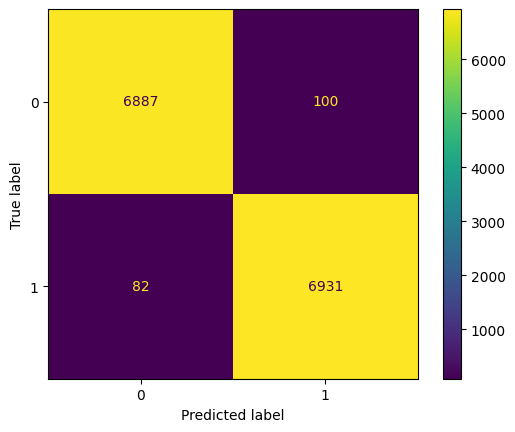

In [18]:
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred: np.ndarray = classifier.predict(X_test)

score: float = classifier.score(X=X_test, y=y_test)
accuracy: float = accuracy_score(y_true=y_test, y_pred=y_pred)
mse: float | np.ndarray = mean_squared_error(y_true=y_test, y_pred=y_pred)
c_report: str | dict = classification_report(y_true=y_test, y_pred=y_pred)
c_matrix: np.ndarray = confusion_matrix(y_true=y_test, y_pred=y_pred)

print("Score:", score)
print("Accuracy:", accuracy)
print("Mean squared error:", mse)
print("Classification report:\n", c_report)
# print("Confusion matrix:\n", c_matrix)
ConfusionMatrixDisplay(confusion_matrix=c_matrix).plot()

### Plotting the model

The high dimensional data can be reduced to a 2D representation through applying a PCA.

In [19]:
from sklearn.decomposition import PCA

pca: PCA = PCA(n_components=2)
X_pca: np.ndarray = pca.fit_transform(X_train) # For displaying points in this new layout
support_vectors_pca: np.ndarray = pca.transform(classifier.support_vectors_) # Used to display actual support vectors

The variance of the PCA is also important to note. It thankfully captures the data well.

In [20]:
explained_variance: np.ndarray = pca.explained_variance_ratio_ * 100
print(f"PC1 explains {explained_variance[0]:.2f}% of the variance")
print(f"PC2 explains {explained_variance[1]:.2f}% of the variance")
print(f"Variance explained by all principal components: {pca.explained_variance_ratio_.sum() * 100:.2f}%")

PC1 explains 98.59% of the variance
PC2 explains 0.31% of the variance
Variance explained by all principal components: 98.90%


Let's set up our points to plot.

In [21]:
h: float; x_min: float; x_max: float; y_min: float; y_max: float;

h = 0.02
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1

xx: np.ndarray; yy: np.ndarray; zz: np.ndarray;

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In order for our PCA plot to correctly show our model's output we have to predict our outputs in this new space and then reshape the predicted outputs to align with the axis.

In [22]:
y_pred: np.ndarray = classifier.decision_function(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
zz_distances: np.ndarray = y_pred.reshape(xx.shape)
zz = (zz_distances > 0)

Let's set up our visual boundaries, which should make the distinction between points much clearer.

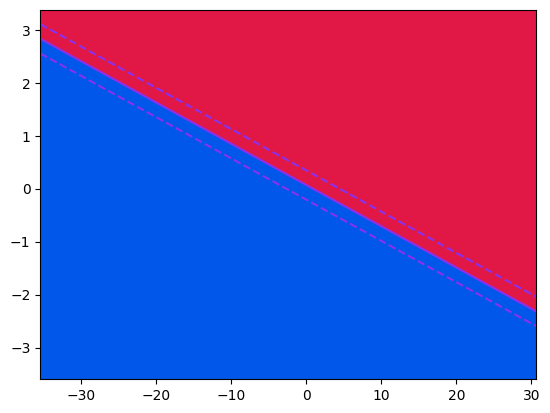

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from sklearn.inspection import DecisionBoundaryDisplay

# ---- Styling ----
# from matplotlib import colormaps, colors
from matplotlib.colors import ListedColormap
from matplotlib.contour import QuadContourSet
# print(colormaps)
# print(colors.cnames)
HIGH_RISK_COLOR: str = "#E11845"
LOW_RISK_COLOR: str = "#0057E9"
EDGE_COLOR: str = "#87E911"
LABEL_LINE_COLOR: str = "#8931EF"
LABEL_TEXT_COLOR: str = "#F2CA19"

split_color_map: ListedColormap = ListedColormap([LOW_RISK_COLOR, HIGH_RISK_COLOR])

# ---- End Styling ----

fig: Figure; ax: plt.Axes;

fig, ax = plt.subplots()

ax.contour(xx, yy, zz_distances, levels=[0], colors=LABEL_LINE_COLOR, linestyles="-")  # Decision boundary
ax.contour(xx, yy, zz_distances, levels=[-1, 1], colors=LABEL_LINE_COLOR, linestyles="--")  # Margins

dbd: DecisionBoundaryDisplay = DecisionBoundaryDisplay(
    xx0=xx,
    xx1=yy,
    response=zz,
)

dbd.plot(plot_method="pcolormesh", ax=ax, cmap=split_color_map)

Time to plot it all together!

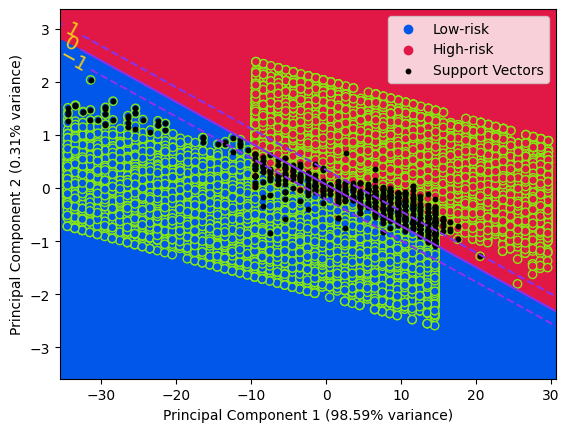

In [24]:
plt.contourf(xx, yy, zz, cmap=split_color_map)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=split_color_map, edgecolors=EDGE_COLOR)
plt.scatter([], [], color=LOW_RISK_COLOR, label="Low-risk")
plt.scatter([], [], color=HIGH_RISK_COLOR, label="High-risk")

plt.scatter(support_vectors_pca[:, 0], support_vectors_pca[:, 1], facecolors="black", s=10, label="Support Vectors")

contourSet: QuadContourSet = plt.contour(xx, yy, zz_distances, levels=[0], colors=LABEL_LINE_COLOR, linestyles="-")  # Decision boundary
plt.clabel(contourSet, inline=1, colors=LABEL_TEXT_COLOR, fontsize="x-large")
contourSet = plt.contour(xx, yy, zz_distances, levels=[-1, 1], colors=LABEL_LINE_COLOR, linestyles="--")  # Margins
plt.clabel(contourSet, inline=1, colors=LABEL_TEXT_COLOR, fontsize="x-large")

plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.2f}% variance)')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.2f}% variance)')
# plt.title('SVM Decision Boundary for Heart Attack Risk (PCA-Reduced from 18D)')
plt.legend()
plt.show()

### Additional Metrics

The features sorted by most indicative of a heart attack.

In [25]:
import pandas as pd

feature_list: list[str] = kUtils.get_feature_list()

feature_importance: pd.DataFrame = pd.DataFrame(
    pca.components_,
    columns=[feature_list[i] for i in range(len(X_train[0,]))],
    index=['PC1', 'PC2'],
)
feature_importance = feature_importance.sort_values(by=["PC1", "PC2"], axis="columns", ascending=False)

print("Feature Contributions to Principal Components:\n", feature_importance.T)

Feature Contributions to Principal Components:
                           PC1       PC2
Age                  0.999270 -0.038178
Pain_Arms_Jaw_Back   0.011253  0.281978
Chest_Pain           0.011232  0.280557
Cold_Sweats_Nausea   0.011225  0.282816
Dizziness            0.011196  0.285275
Fatigue              0.011112  0.285446
Swelling             0.011093  0.281722
Shortness_of_Breath  0.011063  0.283069
Palpitations         0.011018  0.283460
Sedentary_Lifestyle  0.007555  0.202702
High_Cholesterol     0.007511  0.208689
High_BP              0.007470  0.203194
Obesity              0.007440  0.203206
Smoking              0.007343  0.198592
Diabetes             0.007301  0.205079
Family_History       0.007256  0.204228
Chronic_Stress       0.007242  0.206128
Gender               0.005388  0.157207


Let's validate our model.

Score: 0.9847142857142858
Accuracy: 0.9847142857142858
Mean squared error: 0.015285714285714286
Classification report:
               precision    recall  f1-score   support

         0.0       0.99      0.98      0.98     10488
         1.0       0.98      0.99      0.98     10512

    accuracy                           0.98     21000
   macro avg       0.98      0.98      0.98     21000
weighted avg       0.98      0.98      0.98     21000

Confusion matrix:
 [[10321   167]
 [  154 10358]]


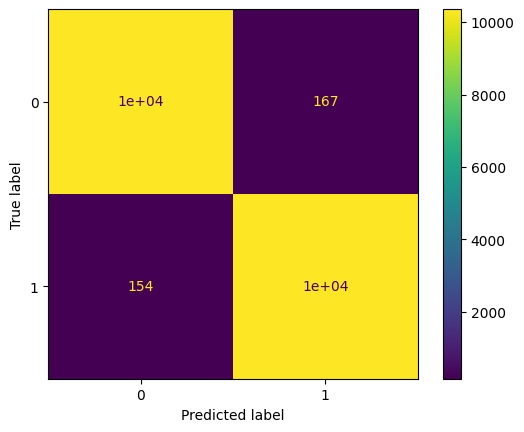

In [26]:
y_pred = classifier.predict(X_val)

score = classifier.score(X=X_val, y=y_val)
accuracy = accuracy_score(y_true=y_val, y_pred=y_pred)
mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
c_report = classification_report(y_true=y_val, y_pred=y_pred)
c_matrix = confusion_matrix(y_true=y_val, y_pred=y_pred)

print("Score:", score)
print("Accuracy:", accuracy)
print("Mean squared error:", mse)
print("Classification report:\n", c_report)
print("Confusion matrix:\n", c_matrix)
ConfusionMatrixDisplay(confusion_matrix=c_matrix).plot()